# Tracking growth of shoots across time series in a fully automated pipeline for high throughput phenotyping

In this notebook we will demonstrate the steps of the pipeline used to extract the individual shoots and track their growth across an image time series.
Bellow is a summary of the steps:

1. Load the image time series and reduce resolution (in order to make processing faster)
1. Segment shoots from images (semantic segmentation with DL)
    1. Post-process the segmented shoots to ensure they are mostly continuous (dilution/opening/skeletonisation)
1. Identify pot rim (circle Hough Transform)
1. Shoot identification
    1. Identify shoots belonging to a pot
    1. Identify individual within a pot (within a sector)
1. Tracking development (area of shoot relative to sector)

In [1]:
from utils.image_utils import load_image_ts, reduce_resolution, white_balance
from utils.skeleton_utils import get_endpoints
import cv2
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
from PIL import Image
from utils.dl.niab import IMG_TRANSFORMS
from skimage.morphology import skeletonize
from scipy.ndimage import label, generate_binary_structure
from utils.dl.model import MCDUNet

/home/users/ashine/miniconda3/envs/niab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Load and pre-process images

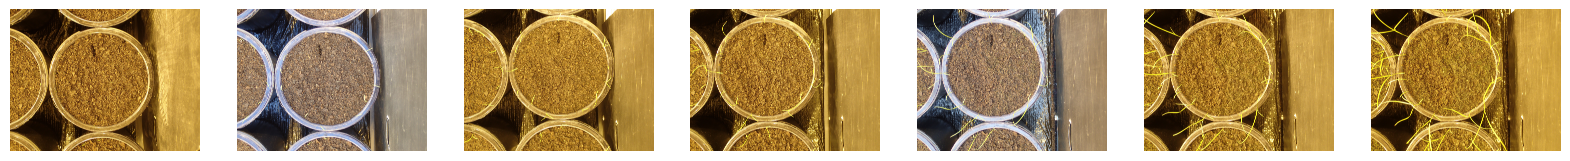

In [2]:
# TODO: Handle edge case of blocks 2 (missing), 3, 4 (TIF, JPG)
# Load image time series and display
raw_images = load_image_ts(dataset_root = "../datasets/niab",
                       exp = 1,
                       block = 1,
                       pot = 31)

fig, ax = plt.subplots(1, len(raw_images), figsize=(20, 20))
for i, image in enumerate(raw_images):
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

In [3]:
# Reduce resolution of images to 10% of the original size to speed up 
# processing (notably segmentation and circle detection)
small_images = [reduce_resolution(image, 10) for image in raw_images]

print("Original image size: ", raw_images[0].shape)
print("Reduced image size: ", small_images[0].shape)

Original image size:  (3456, 4608, 3)
Reduced image size:  (345, 460, 3)


## Step 2: Shoot segmentation

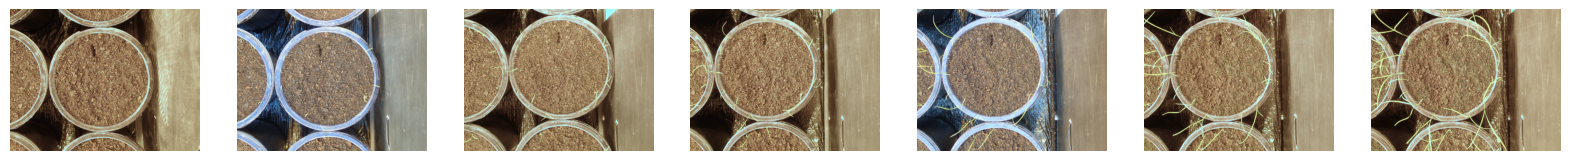

In [4]:
# White balance images to make them more similar across the time series and 
# display
wb_small_images = [white_balance(image) for image in small_images]

fig, ax = plt.subplots(1, len(wb_small_images), figsize=(20, 20))
for i, image in enumerate(wb_small_images):
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

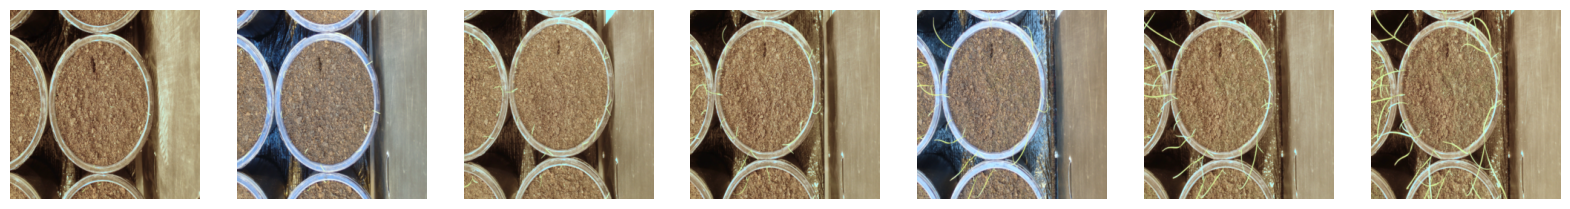

In [5]:
# Transform images for input to the shoot segmentation model
transformed_wb_small_images = [IMG_TRANSFORMS(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))) for image in wb_small_images]

# display the transformed images
fig, ax = plt.subplots(1, len(transformed_wb_small_images), figsize=(20, 20))
for i, image in enumerate(transformed_wb_small_images):
    ax[i].imshow(image.permute(1, 2, 0))
    ax[i].axis('off')

Running model using cuda device


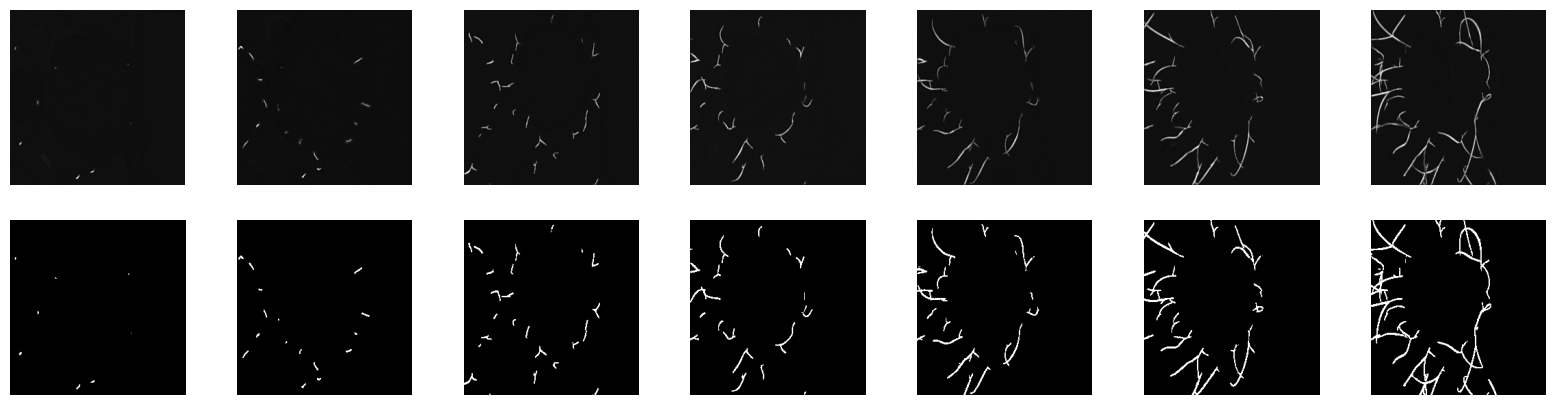

In [6]:
MODEL_PATH = "../models/20240517133228/best_model.pth"
THRESHOLD = 0.7

device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running model using {device} device")

# Create an instance of the model and move it to the device (GPU or CPU) and load the model parameters
unet_dims = []
for i in range(5):
    unet_dims.append(2**(5 + i))

# # Create an instance of the model and move it to the device (GPU or CPU)
model = MCDUNet(n_channels=3,
             n_classes=1,
             bilinear=True,
             ddims=unet_dims,
             UQ=True,
             ).to(device)

# model = smp.Unet(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=1,                      # model output channels (number of classes in your dataset)
# ).to(device)

model.load_state_dict(torch.load(MODEL_PATH))
model.eval()  # Set model to evaluation mode i.e. doesn't change weights

# Inference on the transformed images
predictions = [model(image.unsqueeze(0).to(device)) for image in transformed_wb_small_images]

# Generate binary predictions from the model output
binary_predictions = [prediction.squeeze(0).squeeze(0) > THRESHOLD for prediction in predictions]

# Display predictions and binary predictions
fig, ax = plt.subplots(2, len(predictions), figsize=(20, 5))
for i, (prediction, binary_prediction) in enumerate(zip(predictions, binary_predictions)):
    ax[0, i].imshow(prediction.squeeze(0).squeeze(0).cpu().detach().numpy(), cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(binary_prediction.cpu().detach().numpy(), cmap='gray')
    ax[1, i].axis('off')

In [18]:
# Increase continuity of the binary predictions by opening (an erosion 
# operation followed by a dilation operation) 
kernel = np.ones((1,1),np.uint8)  # 1x1 kernel does nothing
opened_resized_predictions = [cv2.morphologyEx(prediction.cpu().numpy().astype(np.uint8), cv2.MORPH_OPEN, kernel) for prediction in binary_predictions]

fig, ax = plt.subplots(1, len(small_images), figsize=(20, 5))
for i, image in enumerate(small_images):
    ax[i].imshow(opened_resized_predictions[i], cmap='gray')
    ax[i].axis('off')

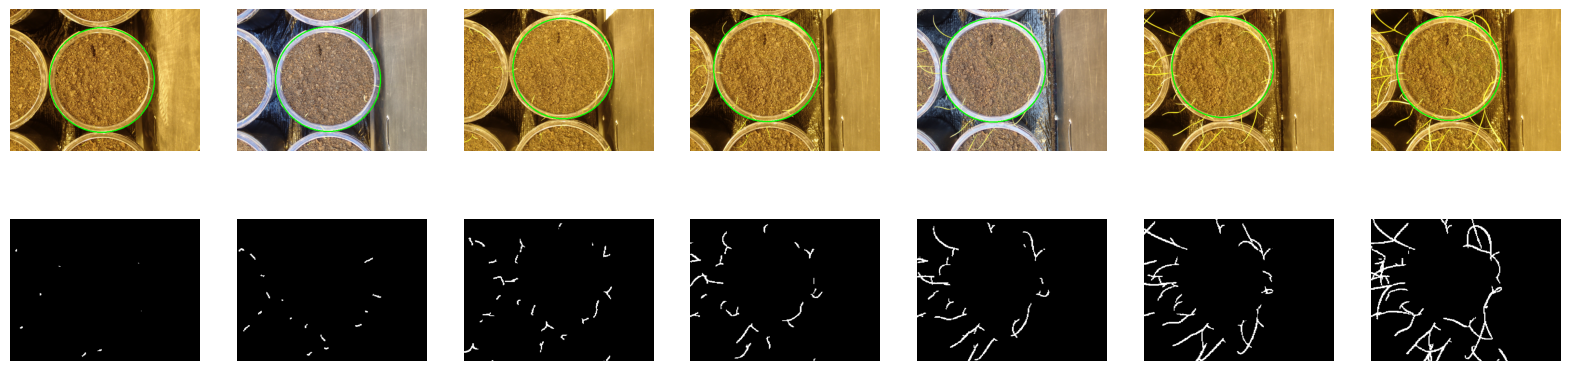

In [13]:
# Resize the predictions so that they match with the small images
resized_predictions = [cv2.resize(prediction, (small_images[0].shape[1], small_images[0].shape[0]), interpolation=cv2.INTER_NEAREST) for prediction in opened_resized_predictions]

# plot the images (row 1 ) and the predictions (row 2)
fig, ax = plt.subplots(2, len(small_images), figsize=(20, 5))
for i, image in enumerate(small_images):
    ax[0, i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0, i].axis('off')
    ax[1, i].imshow(resized_predictions[i], cmap='gray')
    ax[1, i].axis('off')

## Step 3: Identifying pot rims

[((222, 172), 129), ((220, 170), 126), ((238, 140), 128), ((186, 144), 131), ((188, 140), 133), ((190, 140), 121), ((190, 150), 133)]


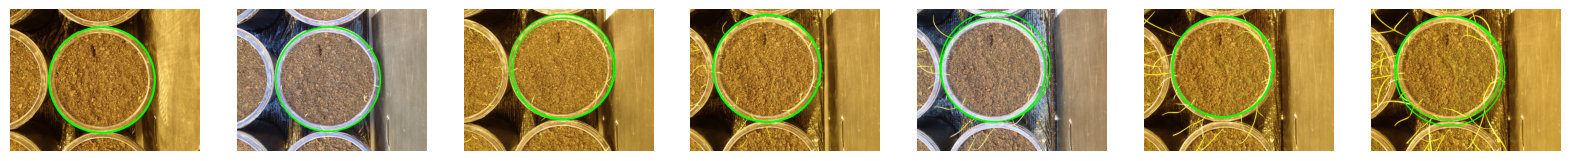

In [14]:
# Convert the images to greyscale for circle detection
grey_small_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in small_images]

saved_circles = []  # [((x, y), r)...]

# Detect circles in each greyscale image
for i, img in enumerate(grey_small_images):
    # Use HoughCircles to detect circles in the image
    # Parameters have been tuned to detect the pot rim in the images (might need to be adjusted for other images)
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 100, param1=50, param2=30, minRadius=120, maxRadius=135)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]
            saved_circles.append((center, radius))
            cv2.circle(small_images[i], center, radius, (0, 255, 0), 2)

print(saved_circles)

fig, ax = plt.subplots(1, len(small_images), figsize=(20, 20))
for i, image in enumerate(small_images):
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

## Step 4: Shoot identification

### Step 4 (a): Identify shoots belonging to pot

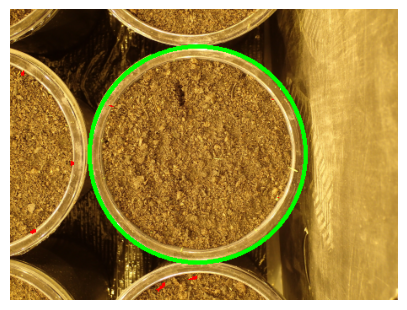

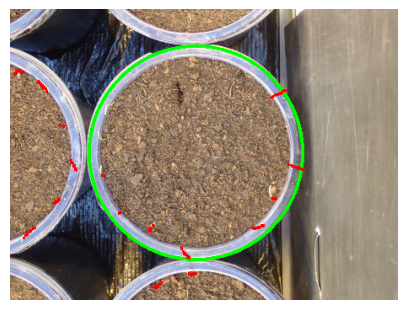

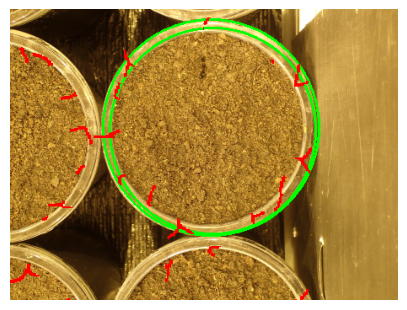

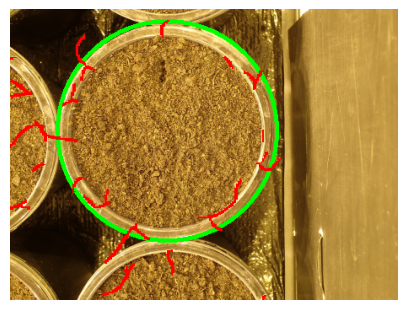

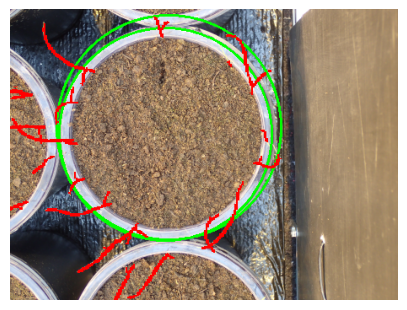

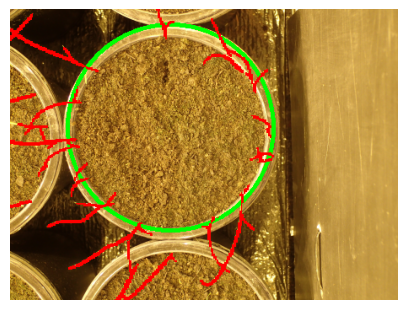

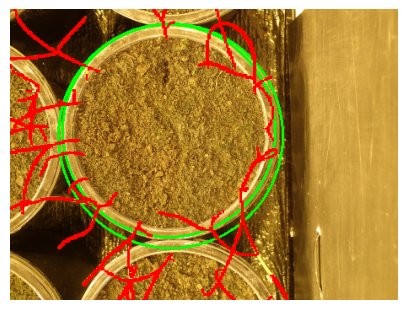

In [15]:
# Overlay the circle on the predictions
for i, (img, prediction) in enumerate(zip(small_images, resized_predictions)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img[prediction == 1] = [255, 0, 0]

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(img)
    ax.axis('off')

    plt.show()

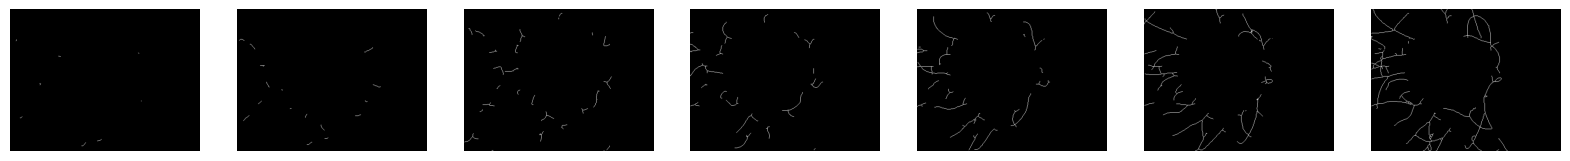

In [14]:
# Skeletonize the binary predictions masks to run logic on the geometry of the shoots and the pot rim
skeletonised_masks = [skeletonize(prediction) for prediction in resized_predictions]

# plot the skeletonised mask
fig, ax = plt.subplots(1, len(skeletonised_masks), figsize=(20, 20))
for i, skeleton in enumerate(skeletonised_masks):
    ax[i].imshow(skeleton, cmap='gray')
    ax[i].axis('off')

Number of labels: 8
Number of labels post filtering: 3
Number of labels: 16
Number of labels post filtering: 8
Number of labels: 26
Number of labels post filtering: 11
Number of labels: 19
Number of labels post filtering: 12
Number of labels: 19
Number of labels post filtering: 12
Number of labels: 14
Number of labels post filtering: 11
Number of labels: 13
Number of labels post filtering: 8


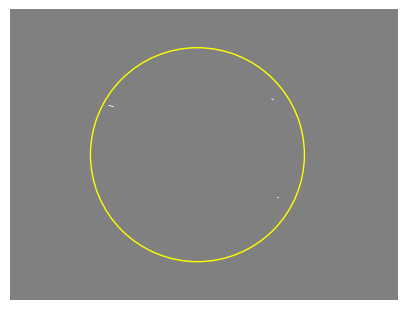

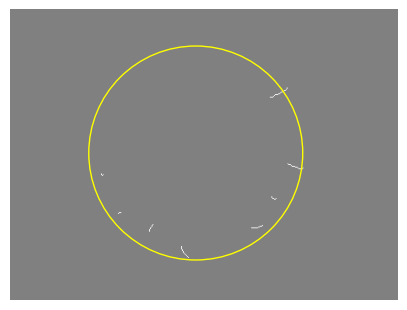

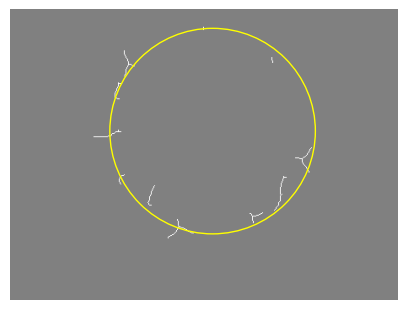

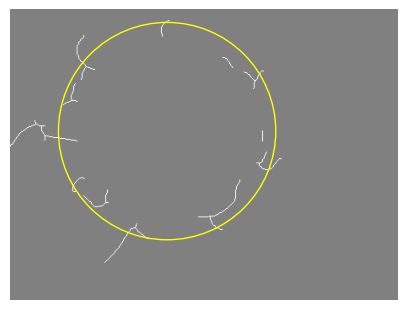

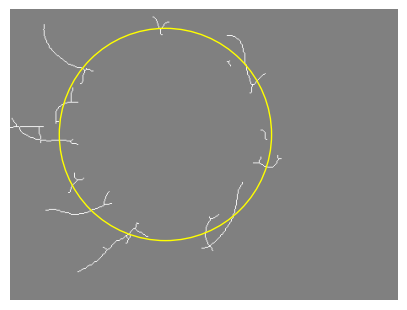

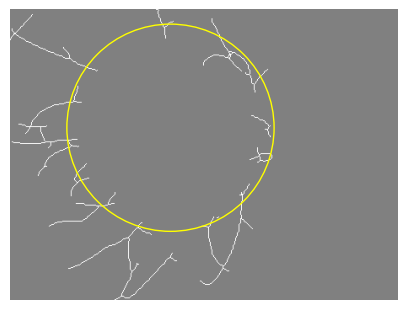

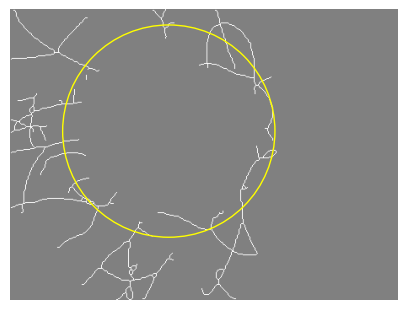

In [15]:
# Array of filtered masks
filtered_masks = []

# Create a structuring element for 8-connectivity
s = generate_binary_structure(2,2)

for skeletonised_mask_nb in range(len(skeletonised_masks)):

    circle_coords = saved_circles[skeletonised_mask_nb]  # ((x, y), r)

    # The label function from scipy.ndimage uses 4-connectivity by default
    # Assuming `skeleton` is your skeletonized image
    labeled_skeletons, num_labels = label(skeletonised_masks[skeletonised_mask_nb], structure=s)

    print(f"Number of labels: {num_labels}")

    # new image of the same shape as skeleton where only the labeled_skeletons that 
    # meet the is_in_circle condition are added
    new_image = np.zeros_like(skeletonised_masks[skeletonised_mask_nb]).astype(np.uint8)

    for skeleton in range(1, num_labels + 1):

        # Create a new image where the random label is highlighted
        highlighted = np.where(labeled_skeletons == skeleton, 1, 0)

        end_points = get_endpoints(highlighted)

        # # if at least 1 endpoint is within the circle, then we have to assume that the shoot is part of the pot
        # # This could later be improved to: if an endpoint with within a certain distance of the circle, then the shoot is part of the pot as we know that the seeds were planted along the rim of the pot
        is_in_circle = False
        for point in end_points:
            in_circle = ((point[0] - circle_coords[0][1])**2 + (point[1] - circle_coords[0][0])**2) <= circle_coords[1]**2
            if in_circle:
                # print(f"End point {point} is within the circle")
                is_in_circle = True
                break

        # print(f"Is in circle: {is_in_circle}")

        if is_in_circle:
            new_image += highlighted.astype(np.uint8)

    # nb of labels post filtering
    labeled_skeletons, num_labels = label(new_image, structure=s)
    print(f"Number of labels post filtering: {num_labels}")

    filtered_masks.append(new_image)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    # ax.imshow(skeletonised_masks[skeletonised_mask_nb], cmap='gray')
    plt.axis('off')

    # Display the circle
    circle = plt.Circle(circle_coords[0], circle_coords[1], color='yellow', fill=False)
    ax.add_artist(circle)

    # Overlay the new image on the skeleton
    ax.imshow(new_image, cmap='gray', alpha=0.5)
    plt.plot()

Number of labels in original: 8
Number of labels in skeleton: 3
Number of labels in original: 16
Number of labels in skeleton: 8
Number of labels in original: 26
Number of labels in skeleton: 11
Number of labels in original: 19
Number of labels in skeleton: 12
Number of labels in original: 19
Number of labels in skeleton: 12
Number of labels in original: 14
Number of labels in skeleton: 11
Number of labels in original: 13
Number of labels in skeleton: 8


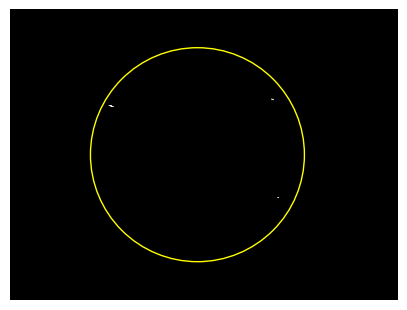

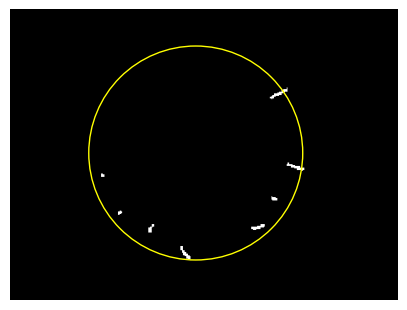

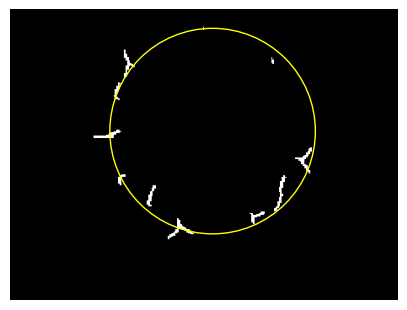

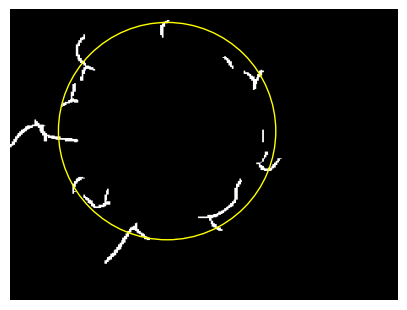

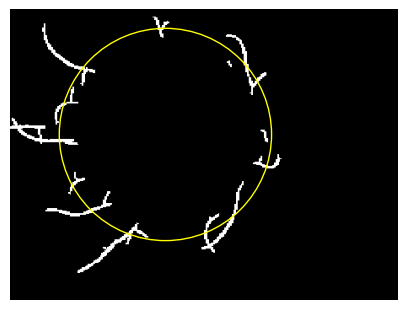

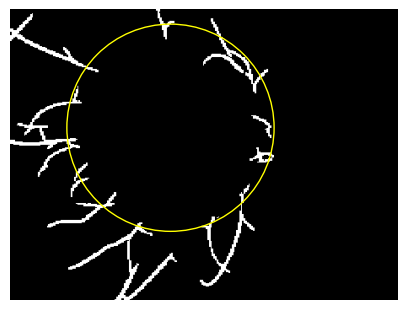

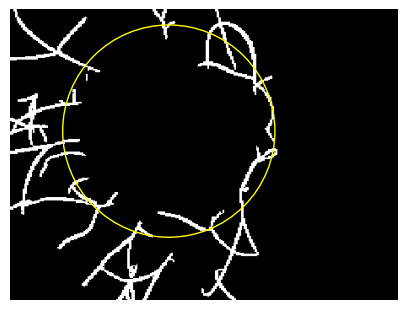

In [16]:
# Using predicted masks instead of skeletonised masks

updated_masks = []

for original, skeleton in zip(resized_predictions, filtered_masks):
    # Perform an "and" operation (logical and)
    labeled_original, num_labels_og = label(original, structure=s)
    labeled_skeleton, num_labels = label(skeleton, structure=s)

    print(f"Number of labels in original: {num_labels_og}")
    print(f"Number of labels in skeleton: {num_labels}")

    new_image = np.zeros_like(original).astype(np.uint8)

    for skeleton in range(1, num_labels + 1):
        # get the highlighted area
        highlighted = np.where(labeled_skeleton == skeleton, 1, 0)

        # get the label of the orifinal image that corresponds to the shape in the skeleton i.e. find the shoot in the original image that corresponds to its skeleton
        # i.e find the label in the original image that has the most overlap with the skeleton
        max_overlap = 0
        best_label = 0
        for og in range(1, num_labels_og + 1):
            overlap = np.sum(np.logical_and(np.where(labeled_original == og, 1, 0), highlighted))
            if overlap > max_overlap:
                max_overlap = overlap
                best_label = og

        new_image += np.where(labeled_original == best_label, 1, 0).astype(np.uint8)

    updated_masks.append(new_image)


for i, updated_mask in enumerate(updated_masks):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(updated_mask, cmap='gray')
    plt.axis('off')

    # Display the circle
    circle = plt.Circle(saved_circles[i][0], saved_circles[i][1], color='yellow', fill=False)
    ax.add_artist(circle)

    plt.plot()

### Step 4 (b): Identifying individual within pot

Processing image 0
Number of labels: 3
End points: [[106 310]
 [107 312]]
Angle: 324.16234704572173, Sector: 14
End points: [[114 117]
 [115 122]]
Angle: 208.9154243416267, Sector: 9
End points: [[223 317]
 [223 318]]
Angle: 27.979474388480146, Sector: 1
Processing image 1
Number of labels: 8
End points: [[ 93 328]
 [104 308]]
Angle: 323.13010235415595, Sector: 14
End points: [[183 329]
 [188 347]]
Angle: 6.801314823981575, Sector: 0
End points: [[195 108]
 [196 110]]
Angle: 167.41703750592308, Sector: 7
End points: [[222 310]
 [224 315]]
Angle: 29.614811646346425, Sector: 1
End points: [[241 131]
 [242 128]]
Angle: 141.95295746817393, Sector: 6
End points: [[255 169]
 [263 165]]
Angle: 120.59997869320895, Sector: 5
End points: [[256 299]
 [259 286]]
Angle: 47.42927332349997, Sector: 2
End points: [[281 203]
 [294 211]]
Angle: 94.1512852664217, Sector: 4
Processing image 2
Number of labels: 11
End points: [[ 21 229]
 [ 24 229]]
Angle: 264.7625239331875, Sector: 11
End points: [[ 49 135

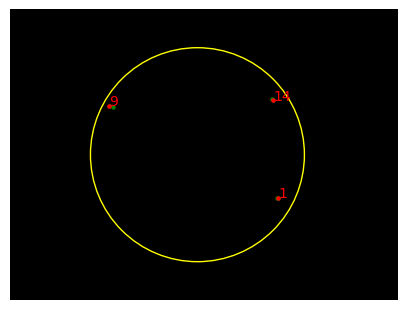

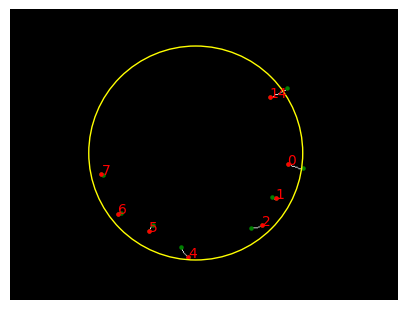

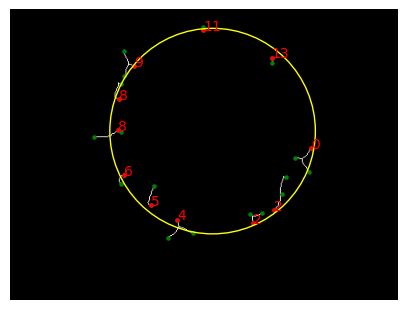

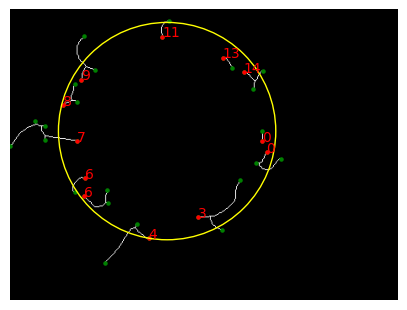

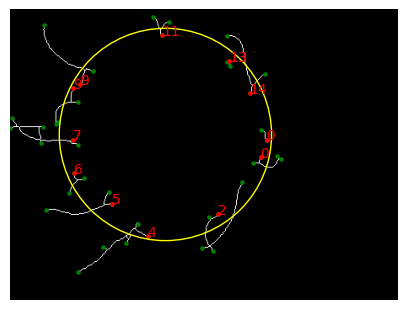

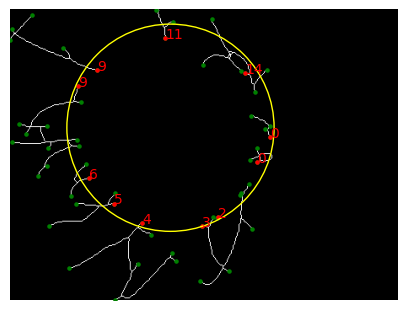

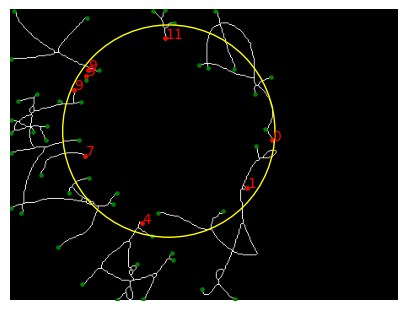

In [17]:
# For each img in the time series, break down the circle into 16 sectors and determine which shoot is in which segment

def get_sectors(endpoints: list, circle_coords: tuple, nb_sectors: int, ax) -> int:
    """
    Determine the segment of the circle that the shoot is from
    """

    # Get the circle
    (x, y), r = circle_coords

    # remove any endpoints outside of the circle
    endpoints = [point for point in endpoints if np.sqrt((point[1] - x)**2 + (point[0] - y)**2) <= r]
    
    # There are edge cases where they may be endpoints in several sctors the shoot tip and the shoot base, we assume that the shoot base is the one that is closest to the rim of the pot so order the endpoints by distance to the rim of the pot
    # sense of the radius - needs to be closer to the radius
    endpoints = sorted(endpoints, key=lambda point: np.sqrt((point[1] - x)**2 + (point[0] - y)**2), reverse=True)
    
    # plot the endpoints[0] in green
    ax.scatter(endpoints[0][1], endpoints[0][0], c='red', s=5)

    # determine sector of the circle that the shoot is in based in the endpoints[0]
    # Calculate the angle of the shoot tip
    angle = np.arctan2(endpoints[0][0] - y, endpoints[0][1] - x) * 180 / np.pi

    # Make sure the angle is positive
    if angle < 0:
        angle += 360

    # Calculate the sector
    sector = int(angle / (360 / nb_sectors))

    # annotate endpoint with the sector number
    ax.annotate(sector, (endpoints[0][1], endpoints[0][0]), color='red')

    print(f"Angle: {angle}, Sector: {sector}")

    return sector
    

# create a csv with 16 columns (one for each sector as sector is equivalent to an individual)
# each row will be a time point
# each cell will be the area of that sector with the shoot in it (ratio value)

tracking_total_length = np.zeros((len(filtered_masks), 16))
tracking_area_sector_ratio = np.zeros((len(filtered_masks), 16))


for i, filtered_mask in enumerate(filtered_masks):
    print(f"Processing image {i}")
    (x, y), r = saved_circles[i]

    sector_area = np.pi * r**2 / 16

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    labeled_skeletons, num_labels = label(filtered_masks[i], structure=s)
    labeled_original_post_filter, _ = label(updated_masks[i], structure=s)

    print(f"Number of labels: {num_labels}")

    for skeleton in range(1, num_labels + 1):
        highlighted = np.where(labeled_skeletons == skeleton, 1, 0)

        highlited_or = np.where(labeled_original_post_filter == skeleton, 1, 0)

        end_points = get_endpoints(highlighted)  # Careful they are returned as [[y, x]]
        print(f"End points: {end_points}")

        # plot the endpoints in green
        for point in end_points:
            ax.scatter(point[1], point[0], c='green', s=5)

        if len(end_points) != 0:
            sector = get_sectors(end_points, saved_circles[i], 16, ax)
            # in theory if there is a one to one relationship between the shoot and the sector this would be a = not a +=
            tracking_total_length[i, sector] += np.sum(highlighted)
            
            # TODO: To make it a ratio divide by the area of the sector
            tracking_area_sector_ratio[i, sector] += np.sum(highlited_or) / sector_area
            
        else:
            print("No endpoints found")
    
    ax.imshow(filtered_mask, cmap='gray')
    plt.axis('off')

    # Display the circle
    circle = plt.Circle((x, y), r, color='yellow', fill=False)
    ax.add_artist(circle)

    plt.plot()

## Step 5: Tracking development

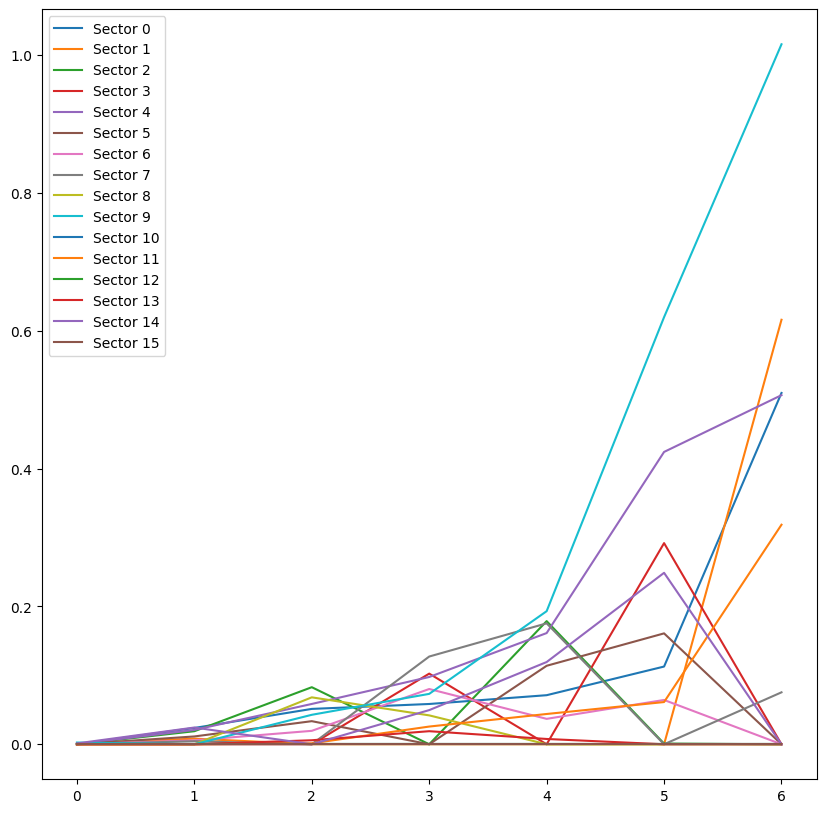

In [18]:
# TODO: at the moment we are using the area of the skeleton - we should be using the area of the actual shoot segmentation within that sector as it is a proxy for what we are aiming for - outcompeting the weeds

# plot tracking colour per sector scatter (x = time, y = value (highlited area), colour = sector)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i in range(16):
    ax.plot(range(len(filtered_masks)), tracking_area_sector_ratio[:, i], label=f"Sector {i}")

plt.legend()